In [7]:
import pandas as pd
import time
import datetime
from datetime import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
from dateutil.parser import parse

In [8]:
def getMetaData(filePath):
    """transfer csv mate data to dataframe"""
    df = pd.read_csv(filePath)
    return df

In [9]:
class Time:
    localTime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())  # YYYY-MM-DD hh:mm:ss
    localDate = localTime.split()[0]  # YYYY-MM-DD
    periodDict = {'week': 7, 'month': 30, 'quarter': 90, 'half a year': 180, 'year': 365}
    daysInWeekList = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    daysInWeekDict = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
    
    
    def getTimePeriod(self):
        # input a time period will be analysed (month as a default)
        timePeriod = input(
                    'Input a time of period that you want to analyse (Input month with ENTER)\n'
                    'ONLY week / month / quarter / half a year / year ARE SUPPORTED: '
                    ).strip() or 'month'
        if timePeriod not in Time.periodDict.keys():
            print('NameError: The Input time period Is Error, Please Input Again.')
            timePeriod = self.getTimePeriod()
        return timePeriod
    
    
    def getDateList(self, startDate: str, endDate: str) -> list:
        """get the date list between start date and end date"""
        dateList = [dt.strftime(x, '%Y-%m-%d') for x in list(pd.date_range(startDate, endDate))]
        return dateList
    
    
    def getPastDate(self, N: int):
        """Get the date before N days (base on today)"""
        pastDate = date.today() - timedelta(days = N)
        pastDate.strftime('%Y-%m-%d')  # 格式化日期
        return pastDate
    
    
    def getNearDate(self, date: str, previous=True):
        """
        Get previous/next date zero O'clock e.g. 2020-05-01 00:00:00
        :params 
            date: a str with YYYY-MM-DD format
            previous: a bool type param which can judge is previous or next day
        """
        return parse(date) - datetime.timedelta(days=1) if previous else parse(date) + datetime.timedelta(days=1)
    
    
    def getTimeInterval(self, t1: str, t2: str):
        """
        Get time interval in second / hour
        :params
            t1 t2: a str with format YYYY-MM-DDThh:mm:ss, which T is delimiter (e.g. 2019-01-14T08:00:38)
                   t1 is the previous time point, t2 is the later time point 
        """
        t1, t2 = parse(t1), parse(t2)
        return int((t2-t1).total_seconds())

    
    def second2hour(self, second):
        """
        Transfer seconds to hours with format '9.50' hours
        ref:
            https://stackoverflow.com/questions/775049/how-do-i-convert-seconds-to-hours-minutes-and-seconds
        :params second: nums
        :return floatHours: float format hour 
        """
        HMS = str(datetime.timedelta(seconds=second))
        hours, minutes = HMS.split(':')[0], HMS.split(':')[1]
        floatHours = float(hours + '.' + minutes)
        return round(floatHours, 2)  # two decimal places
    
    
    def getWeekIndex(self, date):
        """
        Get year, week and the day of the week index
        :params date: a str with YYYY-MM-DD format
        :returns
            year, weekIndex, dayInWeek: 
        """
        YYYY, MM, DD = int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])
        year, weekIndex, dayInWeek = datetime.date(YYYY, MM, DD).isocalendar()
        return year, weekIndex, dayInWeek
        

In [18]:
class Chart:
    def pltChart(self, x: list, y: list, chartType='line', xLabel=None, yLabel=None, label=None, title=None):
        """
        Plot line/bar chart
        params:
            x: x-corrdinate
            y: y-corrdinate
            xLabel: x-corrdinate label
            yLabel: y-corrdinate label
            title: the line chart title
            label: label for multiple content
            chartType: (str) line OR bar
        """
        # TODO: different dimension of date auto scale 
        dimension = np.array(y).ndim  # dimension of values
        barWidth = 0.15
        xCorrdinate = np.arange(len(x))  # temporary x-corrdinate
        stepCoefficient = (len(y) - 1) / 2  # step coefficient decide who long will x-corrdinate move 
#         print(stepCoefficient)
        if len(y) > 10 and dimension >= 2:  # print too many groups of data warning
            print('WARNING: Too many groups of data may cause plt x-corrdinate not accurate')
        
        if len(x[0].split('-')) > 2:
            x = [''.join(day.split('-')[1:]) for day in x]  # re-format YYYY-MM-DD to MMDD 

        X, Y = x, y
        plt.figure(figsize=(15,10))  # TODO: auto size
        if dimension == 1:
            plt.plot(X, Y) if chartType == 'line' else plt.bar(X, Y)
        else:  # multiple dimension data
            for i, subY in enumerate(Y):  # plt each sub data
                if chartType == 'line':
                    plt.plot(np.arange(len(X)), subY, label=label[i])
                else:
                    plt.bar(xCorrdinate, subY, width=barWidth, label=label[i]) 
#                 xCorrdinate += barWidth  # += 不会创建新对象导致TypeError alternatively使用 =+ 或 np.add()
                xCorrdinate = xCorrdinate + barWidth
            plt.xticks(np.arange(len(x)) + barWidth*stepCoefficient, X)  # move corrdinate and replace X-corrdinate with X
            plt.legend()  # 显示图例
        plt.title(title)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.show()

In [11]:
class SuccessAnalysis:
    def __init__(self, df):
        self.df = df
        self.t = Time()
    
    
    def successInDay(self, date=Time.localDate, showResult=False):
        """
        success number / rate in a sepcific day
        :params 
            date: a date with format YYYY-MM-DD, nowtime as the default
            showResult: (bool) whether print result
        :return 
            countTree: (int) the number of trees in the day
            len(dfSuccessTree): (int) the number of successful trees in the day
            successRate: (float) success rate in the day
        """
        boolInDate = self.df['Start Time'].str.contains(date)  # transfer to bool
        dfInDate = self.df[boolInDate]  # get all row meet the date condition
        
        try:
            countTree = len(dfInDate)  # eligible tree number in total
            dfSuccessTree = dfInDate.loc[dfInDate['Is Success'] == True]  # successed tree df
            successRate = round((len(dfSuccessTree) / countTree) * 100, 2)  # success rate
        
        except ZeroDivisionError:
            successRate = None
            if showResult:
                print('You do not have a tree in {}'.format(date), end = '\n\n')
        
        else:
            if showResult:
                print('In {}, there are {} trees, {} of which are successful, the success rate is {}%'
                      .format(date, countTree, len(dfSuccessTree), successRate), end = '\n\n')
            pass
        return countTree, len(dfSuccessTree), successRate if successRate else 0.0  # assign 0 for the day does not have a tree
    
    
    def successInTimePeriod(self):
        """success number / rate in a time of period"""
        periodInDays = Time.periodDict[timePeriod]
        
        pastDate = self.t.getPastDate(periodInDays)
        dateList = self.t.getDateList(pastDate, Time.localDate)
        # get cusscessful rate list correspond to dateList
        successRateList = [self.successInDay(d)[-1] for d in dateList]
        return dateList, successRateList    

    
    def monthAveSucRate(self, days: list):
        """
        Get average success rate according to month
        :params days: a list of days with format YYYY-MM-DD
        :return
            list(treeDict): a list of month
            list(treeDict.values()): a list of success rate correspond to the month 
        formula: 
            number of success in month / number of trees in month
        """
        treeDict = {}  # use a dict to count trees, format with date: [succ, total]
        for day in days:
            countTree, successTree, _ = self.successInDay(day)
            month = '-'.join(day.split('-')[:-1])
            if month not in treeDict:
                treeDict[month] = [successTree, countTree]
            else:
                treeDict[month][0] += successTree
                treeDict[month][1] += countTree
        # calculate success rate
        for key, value in treeDict.items():
            successRate = round((value[0]/value[1])*100, 2) if value[1] != 0 else 0.0
            treeDict[key] = successRate
        return list(treeDict), list(treeDict.values())  # month, success rate
    

In [12]:
class PlantTimeAnalysis:
    def __init__(self, df):
        self.df = df
        self.t = Time()
    
    
    def plantTimeInDay(self, date, inSecond=False):
        """
        Get a specific day plant time in hours
        :params 
            date: a date with YYYY-MM-DD format
            inSecond: a bool to decide second or hour
        :return plantTime: a float type number
        """
        plantTime = 0  # total plant time in a day
        timeInterval1, timeInterval2, timeInterval3 = {}, {}, {} # use dict to store time interval  
        
        """
        https://blog.csdn.net/chihwei_hsu/article/details/81604455
        type 1. date in both start and end time 
        type 2. date in start time but not in end time
        type 3. date not in start time but in end time
        """        
        boolType1 = self.df['Start Time'].str.contains(date) & self.df['End Time'].str.contains(date)
        boolType2 = self.df['Start Time'].str.contains(date) & ~self.df['End Time'].str.contains(date)
        boolType3 = ~self.df['Start Time'].str.contains(date) & self.df['End Time'].str.contains(date)
        
        dfType1, dfType2, dfType3 = self.df[boolType1], self.df[boolType2], self.df[boolType3]
        
        for index, row in dfType1.iterrows():
            timeInterval1[row['Start Time'].split('.')[0]] = row['End Time'].split('.')[0]
        for index, row in dfType2.iterrows():
            nextDate = 'T'.join(str(self.t.getNearDate(row['Start Time'].split('T')[0], previous=False)).split())
            timeInterval2[row['Start Time'].split('.')[0]] = nextDate
        for index, row in dfType3.iterrows():
            previousDate = 'T'.join(str(self.t.getNearDate(row['Start Time'].split('T')[0])).split())
            timeInterval3[row['Start Time'].split('.')[0]] = previousDate
        
        # get total plant time
        for key, value in timeInterval1.items():
            plantTime += self.t.getTimeInterval(key, value)
        for key, value in timeInterval2.items():
            plantTime += self.t.getTimeInterval(key, value)
        for key, value in timeInterval2.items():
            plantTime += self.t.getTimeInterval(key, value)
            
        return plantTime if inSecond else self.t.second2hour(plantTime)
        
        
    def plantTimeInPeriod(self):
        """Plant time in a period of time"""
        plantTimeDict = {}  # a dict is used to store date and plant time 
        
        periodInDays = Time.periodDict[timePeriod]
        pastDate = self.t.getPastDate(periodInDays)
        dateList = self.t.getDateList(pastDate, Time.localDate)
        for date in dateList:
            plantTimeDict[date] = self.plantTimeInDay(date)
        return list(plantTimeDict.keys()), list(plantTimeDict.values())
    
    
    def monthlyPlantTime(self, days: list):
        """
        Get monthly plant time
        :params days: a list of days
        :returns
            list(timeDict.keys()): months
            list(timeDict.values()): monthly plant time
        """
        timeDict = {}  # use a dict to get average plant time, format with month: plantTime
        for day in days:
            plantTime = self.plantTimeInDay(day)
            month = '-'.join(day.split('-')[:-1])
            if month not in timeDict:
                timeDict[month] = plantTime
            else:
                timeDict[month] += plantTime
        return list(timeDict.keys()), list(timeDict.values())  # month, success rate
    
    
    def weeklyPlantTime(self, days: list):
        """
        Get plant time from Mon to Sun in different weeks
        :params days: a list of days
        :returns
            weeklyDict.keys(): year and week index
            weeklyDict.values(): [[]] plant time every day in the week
        """
        periodInDays = Time.periodDict[timePeriod]
        pastDate = self.t.getPastDate(periodInDays)
        dateList = self.t.getDateList(pastDate, Time.localDate)
        
        # TODO: dict - {weekIdex:[1,2,3,4,5,6,7]}
        weeklyDict = {}  # use a dict to store weekIndex and plantTime in the week e.g. {weekIdex:[1,2,3,4,5,6,7]}
        for day in days:
            year, monthIndex, dayInWeek = self.t.getWeekIndex(day)
            year = str(year)[2:]  # last two character in year
            monthIndex = year + 'Y' + str(monthIndex) + 'W'  # Y-year W-week
            if monthIndex not in weeklyDict:
                weeklyDict[monthIndex] = [0] * 7  # record a week plant time
            weeklyDict[monthIndex][dayInWeek-1] = self.plantTimeInDay(day)
        return list(weeklyDict.keys()), list(weeklyDict.values())
    
    
    def aveDaysInWeekPlantTime(self, weekIndex, plantTimeInWeeks):
        """
        Get average days in different week plant time
        :params
            weekIndex: a list of week index that generated by weeklyPlantTime function.
            plantTimeInWeeks: a multiple dimensional list records every day plant time 
                              in different week that generated by weeklyPlantTime function.
        :return avePlantTimeInWeeks: the average days plant time in week
        """
        daysPlantTimeInWeek = [0] * 7  # use a list to store average plant time in different weeks
        avePlantTimeInWeeks = np.array(plantTimeInWeeks).sum(axis=0)  # sum columns (axis=1 - sum rows)
        avePlantTimeInWeeks = list(avePlantTimeInWeeks / len(weekIndex))  # get average
        
        weekNums = len(weekIndex)
        maxTimeIndex = avePlantTimeInWeeks.index(max(avePlantTimeInWeeks))
        minTimeIndex = avePlantTimeInWeeks.index(min(avePlantTimeInWeeks))
        print('In the last {}:'
              '\nThe MAX plant time is in {}, which have {} hours in average' 
              '\nThe MIN plant time is in {}, which have {} hours in average'
              .format(timePeriod, 
                      Time.daysInWeekDict[maxTimeIndex+1], round(avePlantTimeInWeeks[maxTimeIndex], 2),
                     Time.daysInWeekDict[minTimeIndex+1], round(avePlantTimeInWeeks[minTimeIndex], 2)))
        return avePlantTimeInWeeks
     

In [13]:
class TypeAnalysis:
    pass  # TODO: tree type analysis

In [14]:
class TagAnalysis:
    pass  # TODO: tag analysis

Input a time of period that you want to analyse (Input month with ENTER)
ONLY week / month / quarter / half a year / year ARE SUPPORTED: 
The time period will be analysed is: month
In 2020-05-01, there are 3 trees, 1 of which are successful, the success rate is 33.33%



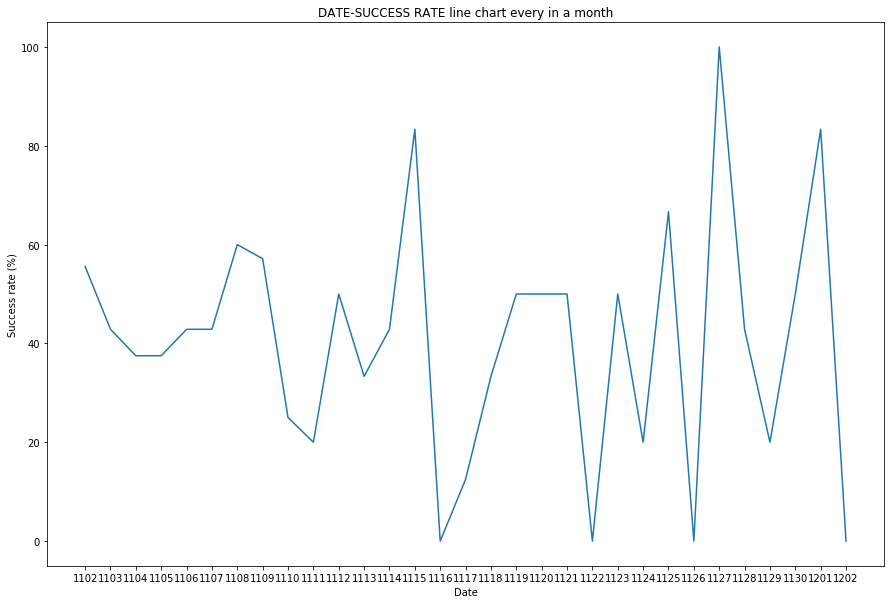

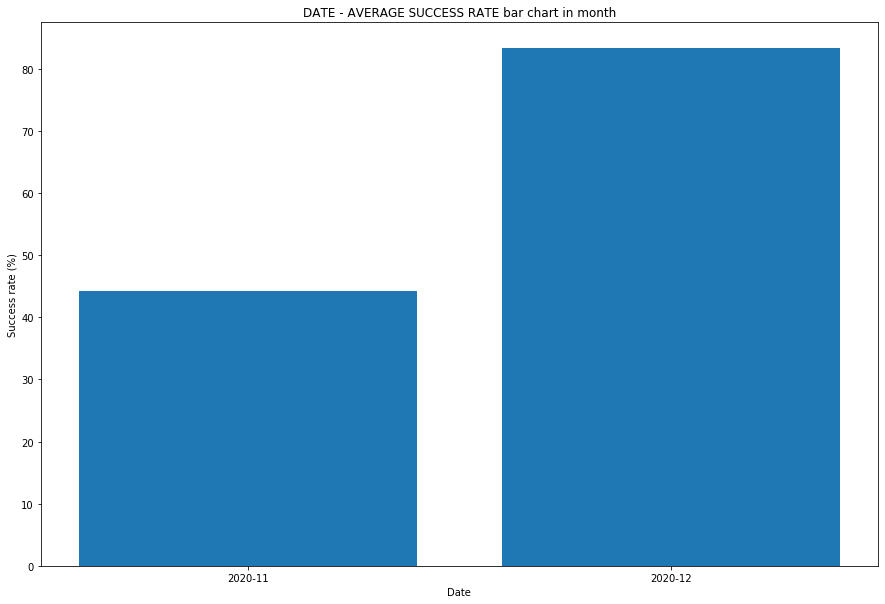

In the day, your plant time is :6.41


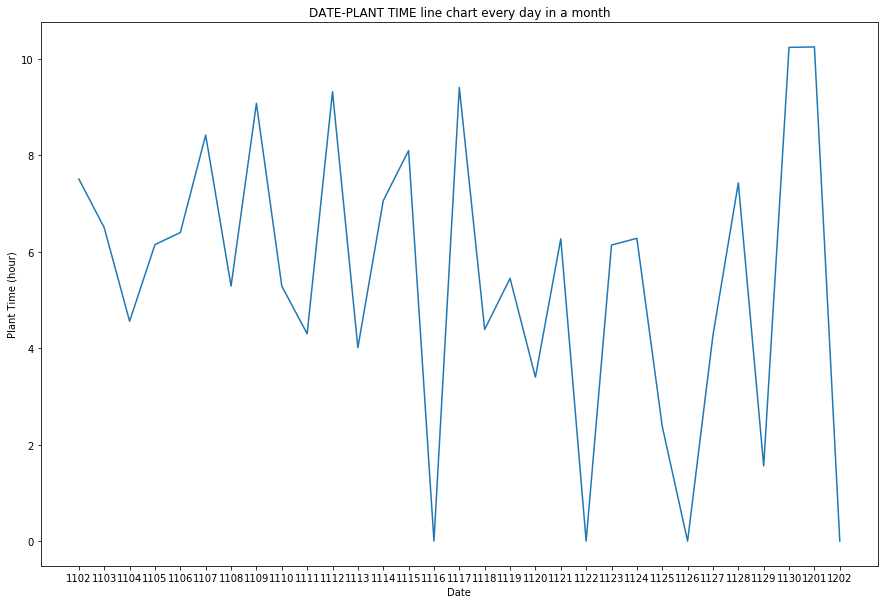

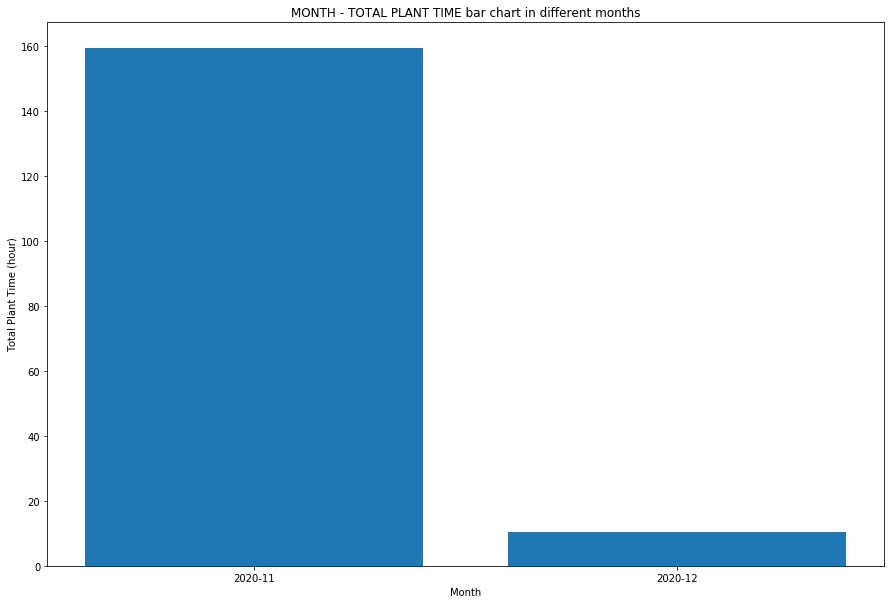

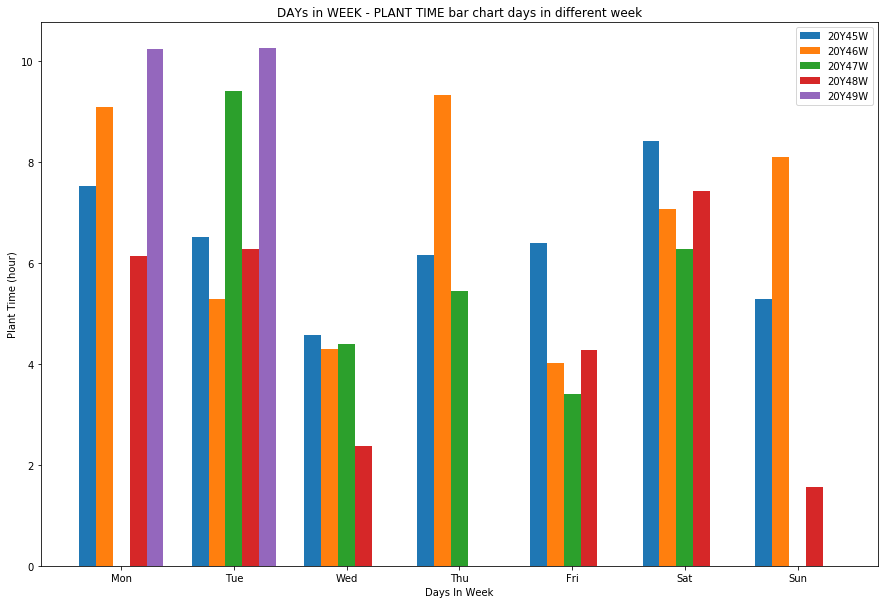

In the last month:
The MAX plant time is in Tue, which have 7.55 hours in average
The MIN plant time is in Sun, which have 2.99 hours in average


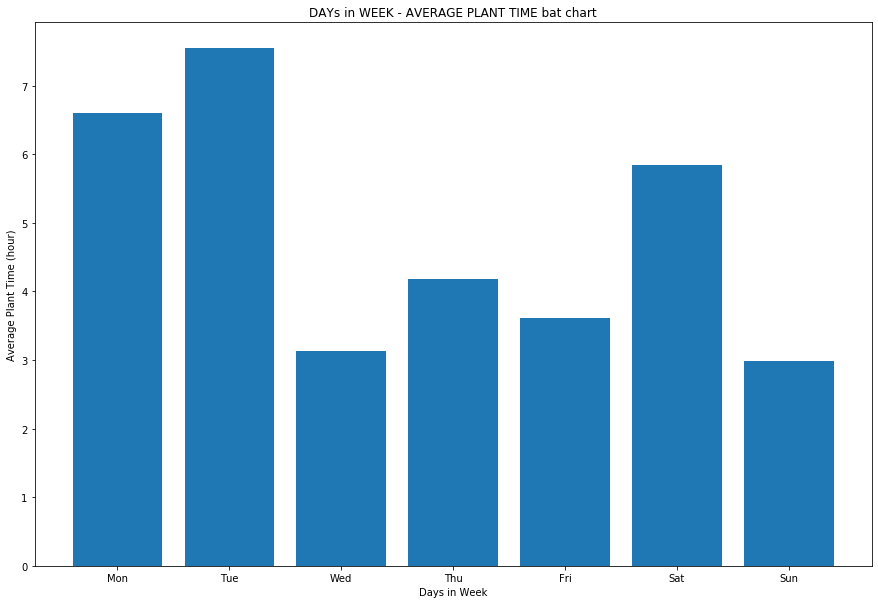

In [19]:
if __name__ == '__main__':
    # get meta date
    filePath = './Plants_of_me.csv'  # repalce with your own file path
    df = getMetaData(filePath)
#     print(df.head(5))  # display data frame
    
    
    
    # input analysis time period
    t = Time()
    timePeriod = t.getTimePeriod()
    print('The time period will be analysed is: {}'.format(timePeriod))
    
    
    
    # success rate analysis
    s = SuccessAnalysis(df)
    _ = s.successInDay(date='2020-05-01',showResult=True)  # analyse a specific date success situation

    days, succ = s.successInTimePeriod()
    Chart.pltChart(Chart, days, succ, 'line', 
                   xLabel='Date', yLabel='Success rate (%)', 
                   title='DATE-SUCCESS RATE line chart every in a month')  # plot success rate in days

    mon, succMon = s.monthAveSucRate(days)
    Chart.pltChart(Chart, mon, succMon, 'bar', 
                   xLabel='Date', yLabel='Success rate (%)', 
                   title='DATE - AVERAGE SUCCESS RATE bar chart in month')  # plot average success rate in months
    
    
    
    # plant time analysis
    p = PlantTimeAnalysis(df)  
    plantDayTime = p.plantTimeInDay('2019-01-13')  # get plant time in the specific date
    print('In the day, your plant time is :{}'.format(plantDayTime))

    days, times = p.plantTimeInPeriod()
    Chart.pltChart(Chart, days, times, chartType='line', 
                   xLabel='Date', yLabel='Plant Time (hour)', 
                   title='DATE-PLANT TIME line chart every day in a month')  # plot plant time in days

    months, monthlyPlantTime = p.monthlyPlantTime(days)
    Chart.pltChart(Chart, months, monthlyPlantTime, chartType='bar',
                  xLabel='Month', yLabel='Total Plant Time (hour)',
                  title='MONTH - TOTAL PLANT TIME bar chart in different months')  # plot average plant time in months

    weekIndex, plantTimeInWeeks = p.weeklyPlantTime(days)
    Chart.pltChart(Chart, Time.daysInWeekList, plantTimeInWeeks, 
                   chartType='bar', xLabel='Days In Week', yLabel='Plant Time (hour)',
                   title='DAYs in WEEK - PLANT TIME bar chart days in different week', 
                   label=weekIndex)  # plot days plant time in weeks

    avePlantTimeInWeeks = p.aveDaysInWeekPlantTime(weekIndex, plantTimeInWeeks)
    Chart.pltChart(Chart, Time.daysInWeekList, avePlantTimeInWeeks, chartType='bar',
                  xLabel='Days in Week', yLabel='Average Plant Time (hour)',
                  title='DAYs in WEEK - AVERAGE PLANT TIME bat chart')  # plot average days plant time in weeks